# 0.0 Imports

In [2]:
import math
import pandas as pd
import numpy as np
import inflection
import datetime


import seaborn as sns

from tabulate             import tabulate
from datetime             import timedelta
from scipy                import stats  as ss
from matplotlib           import pyplot as plt
from IPython.core.display import HTML
from IPython.display      import Image
#from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder



## 0.1. Helper Functions

In [3]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).as_matrix()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def jupyter_settings():
    
    %matplotlib inline 
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize']=[20,10]
    plt.rcParams['font.size']=10
    
    display( HTML('<style>.container {width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    #pd.set_options('display.expand_frame_repr',False )
    
    sns.set()
    

In [4]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

In [5]:
# o argumento low_memory fala para função pd.read para ler todo o arquivo de uma só vez
df_sales_row = pd.read_csv('data/train.csv', low_memory=False)
df_store_row = pd.read_csv('data/store.csv', low_memory=False)

#merge
df_raw = pd.merge(df_sales_row, df_store_row, how='left', on ='Store')

In [6]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
563088,799,3,2014-02-12,8459,839,1,0,0,0,a,c,2700.0,NaN,NaN,0,NaN,NaN,NaN


# 1.0 Descrição dos Dados

## 1.1. Rename Columns

In [7]:
df1 = df_raw.copy()

In [8]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [9]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday',
            'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 
            'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval'] 

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

#Rename
df1.columns = cols_new

## 1.2. Data Dimension

In [10]:
print('Number rows: {}'.format(df1.shape[0]))
print('Number cols: {}'.format(df1.shape[1]))

Number rows: 1017209
Number cols: 18


## 1.3. Data Types

In [11]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [12]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [13]:
df1['competition_distance'].max()

75860.0

In [14]:
#competition_distance 
# Ela vai mostrar se na coluna tem NA o "isnan"
# apply aplica a função em todas as linhas

df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month

df1['competition_open_since_month']= df1.apply( lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year 

df1['competition_open_since_year']= df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)
                               
#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'],axis=1)

#promo2_since_year       

df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval  
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map']= df1['date'].dt.month.map(month_map)


df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval']== 0 else 1 if x['month_map']in x['promo_interval'].split(',') else 0 , axis=1)                 


In [15]:
df1.sample(5).T

,478790,485702,407105,144078,521365
store,126,348,666,244,331
day_of_week,1,2,3,2,5
date,2014-04-28 00:00:00,2014-04-22 00:00:00,2014-07-02 00:00:00,2015-03-24 00:00:00,2014-03-21 00:00:00
sales,9747,8141,8181,4006,5537
customers,724,769,713,434,863
open,1,1,1,1,1
promo,1,0,1,0,1
state_holiday,0,0,0,0,0
school_holiday,0,1,0,0,0
store_type,d,a,c,d,a


## 1.6. Change

In [16]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [17]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7. Descriptive Statistical

In [18]:
#Separar as variáveis numéricas das categóricas

num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes=df1.select_dtypes(include = ['object'])

### 1.7.1 Numerical Attributes

In [19]:
#Central tendencian - mean, median

ct1 = pd.DataFrame( num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion - std, min, max, range, skew, kurtosis

d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

#Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes','min', 'max', 'range', 'mean', 'median', 'std', 'skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999
9,is_promo,0.0,1.0,1.0,0.155231,0.0,0.362124,1.904152,1.625796


C:\Users\bruna\anaconda3\envs\DataScienceEmProducao\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance'>

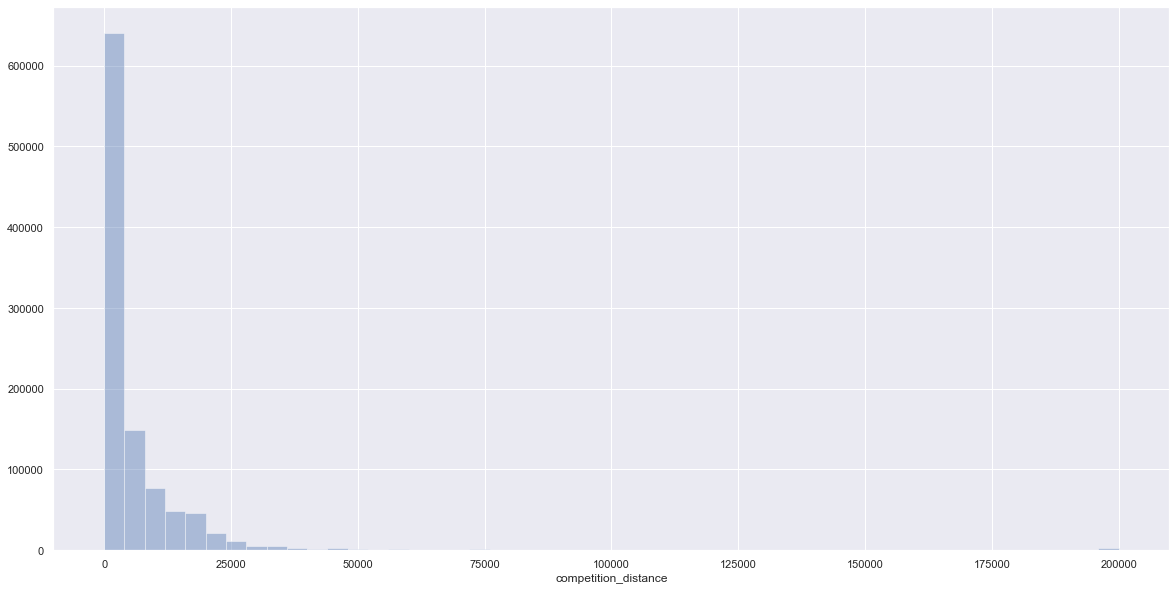

In [20]:
sns.distplot(df1['competition_distance'], kde= False)

### 1.7.2 Categorical Attributes

In [21]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

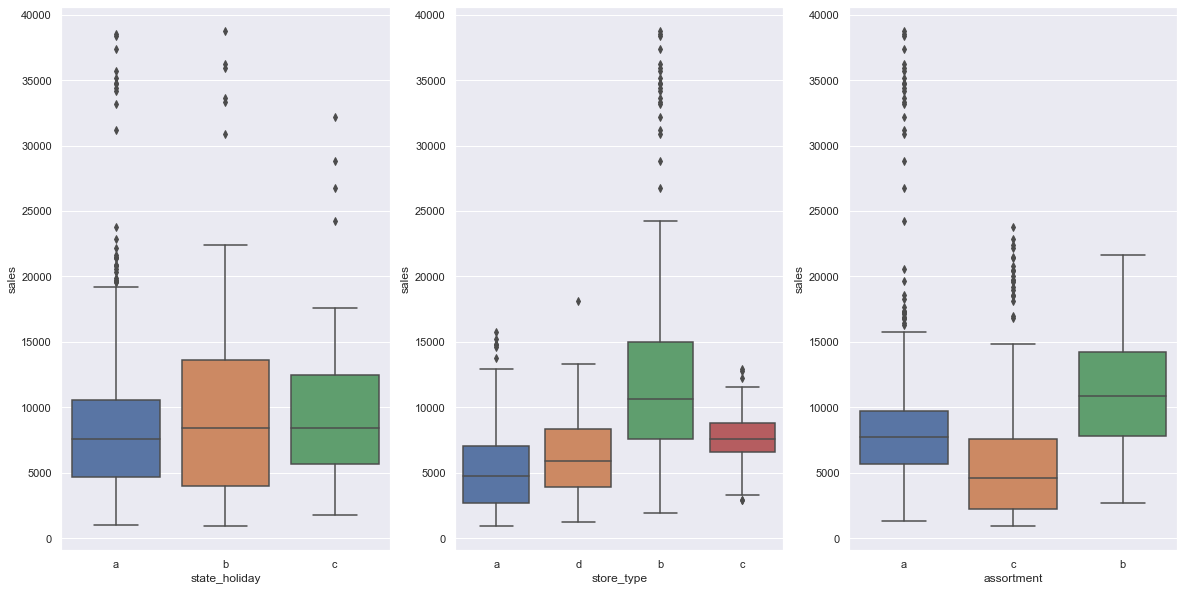

In [22]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0) ]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y= 'sales', data= aux)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y= 'sales', data= aux)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y= 'sales', data= aux)




##### Fenômeno
 
    - É aquilo que você está tentando medir ou modelar
    - Qual o fenômeno você está tentando modelar?

##### Agentes
    - Quem são os agentes atuam sobre o fenômeno de interesse?

##### Atributos dos agentes
    - Qual a descrição dos Agentes?

##### Lista  de Hipóteses:
    - Hipóteses para validar com os dados?

##### Como escrever hipóteses?

# 2.0 Feature Engineering

## 2.1  Mapa das Hipóteses

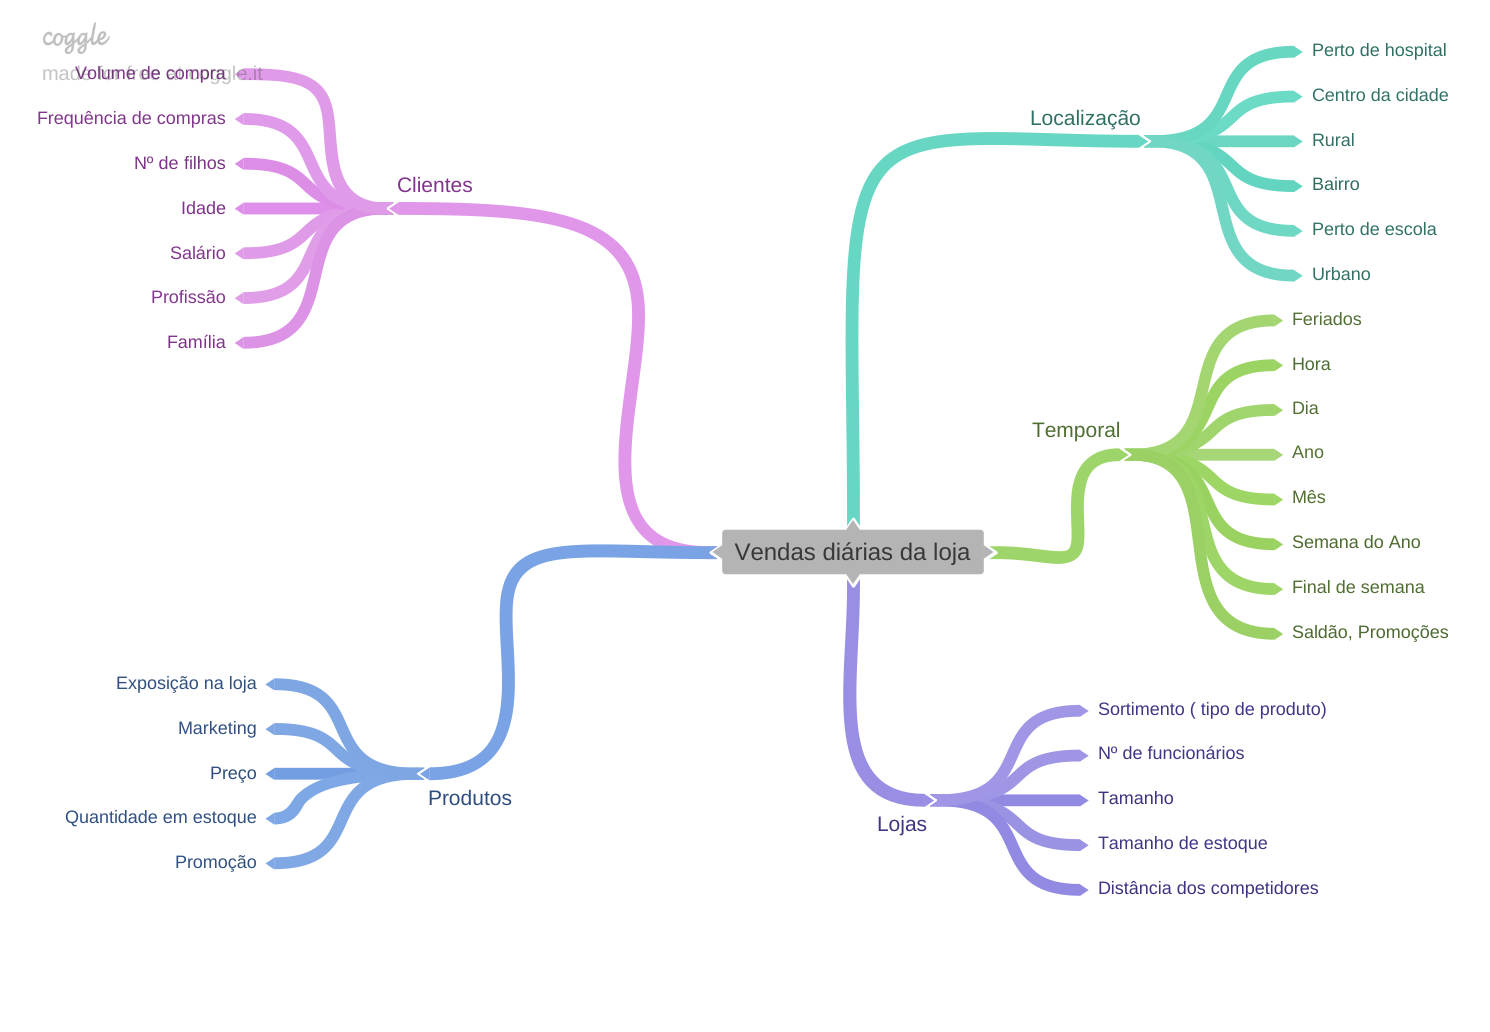

In [23]:
Image('img/MindMapHypothesis.png')

## 2.2 Criação das Hipóteses

### 2.2.1 Hipóteses das Lojas

**1-** Lojas com maior número de funcionários deveriam vender mais.

**2-** Lojas com maior capacidade de estoque deveriam vender mais.

**3-** Lojas com maior porte deveriam vender mais.

**4-** Lojas com competidores mais próximos deveriam vender menos.

**5-** Lojas com maior sortimento deveriam vender mais.

**6-** Lojas com competidores à mais tempo  deveriam vender mais.

### 2.2.2 Hipóteses dos Produtos

**1-** Lojas que investem mais em Marketing deveriam vender mais.

**2-** Lojas com maior exposição de produtos deveriam vender mais.

**3-** Lojas com produtos com preço menor deveriam vender mais.

**4-** Lojas com promoções mais agressivas(descontos maiores), deveriam vender mais.

**5-** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6-** Lojas com mais dias de promoção deveriam vender mais.

**7-** Lojas com mais promoções consecutivas deveriam vender mais.


### 2.2.3 Hipóteses de Tempo

**1-** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2-** Lojas deveriam vender mais ao longo dos anos

**3-** Lojas deveriam vender mais no segundo semestre do ano.

**4-** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5-** Lojas deveriam vender menos aos finais de semana.

**6-** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Hipóteses Finais

- Loja

**1-** Lojas com competidores mais próximos deveriam vender menos.

**2-** Lojas com maior sortimento deveriam vender mais.

**3-** Lojas com competidores à mais tempo  deveriam vender mais.

- Produtos

**4-** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5-** Lojas com mais dias de promoção deveriam vender mais.

**6-** Lojas com mais promoções consecutivas deveriam vender mais.

- Tempo

**7-** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8-** Lojas deveriam vender mais ao longo dos anos

**9-** Lojas deveriam vender mais no segundo semestre do ano.

**10-** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11-** Lojas deveriam vender menos aos finais de semana.

**12-** Lojas deveriam vender menos durante os feriados escolares.


## 2.4 Feature Engineering

In [24]:
df2 = df1.copy()

In [25]:
#year 
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W')


#competition of since
df2['competition_since']= df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since']= df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w')- datetime.timedelta( days=7 ))
df2['promo_since_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

#assortment
df2['assortment'] =df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public holiday' if x == 'a' else 'Easter holiday' if x == 'b' else 'Christmas' if x =='c' else 'regular_day')



In [26]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 Variable Filtering

In [27]:
#Filtragem de variáveis:
# Restrições de Acordo com o Negócio

#Seleção de Variáveis:
#-Variáveis mais relevantes para o modelo

In [28]:
df3 = df2.copy()

In [29]:
df3.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


## 3.1 Rows Filtering

In [30]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Selection Columns

In [31]:
col_drop = ['customers','open','promo_interval','month_map']
df3 = df3.drop(col_drop, axis = 1)

In [32]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_since_week'],
      dtype='object')

# 4.0 - Exploratory Analysis

In [33]:
#Quais os 3 objetivos da EDA?
  #Ganhar experiência de Negócio
  #Validar Hipóteses dde Negócio. (Insights)
  # Perceber variáveis que são importantes para o modelo.
    
# Tem 3 tipos de análise sendo elas:
    #Análise Univariada - Como é essa variável? ( Min, Max, Range, ...) 
    # Análise Bivariada - Como a variável impacta na resposta? (Correlação, validação das hpóteses ..)
    # Análise Multivariadas - Como as variáveis se relacionam? ( Qual a correlação entre elas)
    

In [34]:
df4 = df3.copy()

## 4.1 Analysis Univariate

### 4.1.1 Response Variable

### 4.1.2 Numerical Variable

C:\Users\bruna\anaconda3\envs\DataScienceEmProducao\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\bruna\anaconda3\envs\DataScienceEmProducao\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\bruna\anaconda3\envs\DataScienceEmProducao\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum +

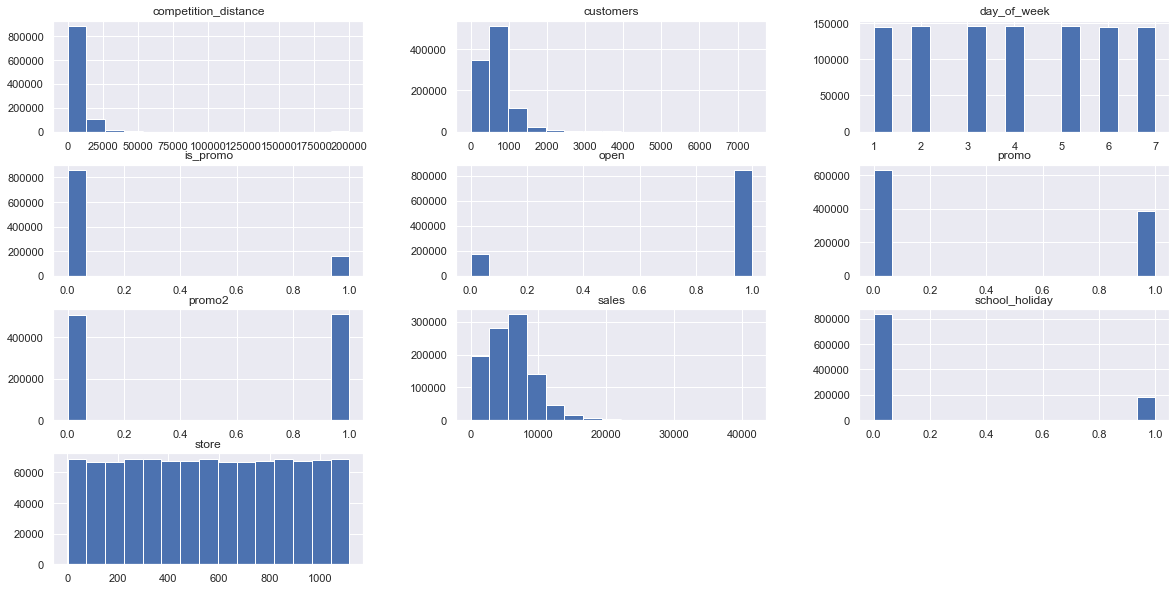

In [35]:
# Arrumar o gráfico
num_attributes.hist(bins=15);

C:\Users\bruna\anaconda3\envs\DataScienceEmProducao\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

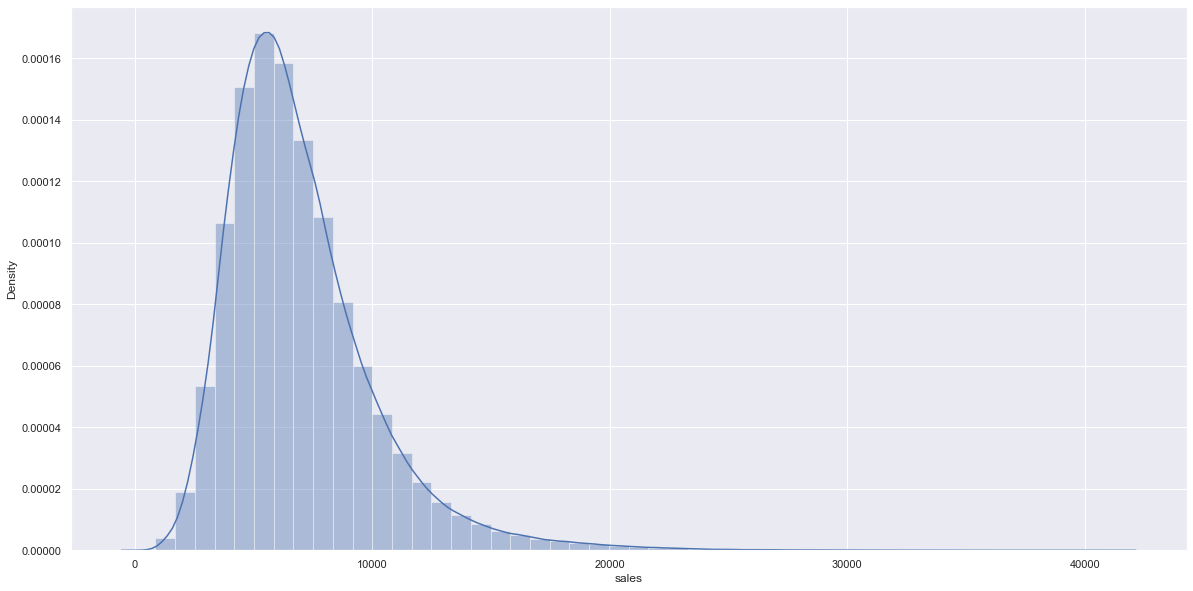

In [36]:
# Arrumar o gráfico
sns.distplot(df4['sales'], kde=True)

### 4.1.3 Categorical Variable

In [37]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public holiday
129424    Easter holiday
241126         Christmas
Name: state_holiday, dtype: object

C:\Users\bruna\anaconda3\envs\DataScienceEmProducao\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

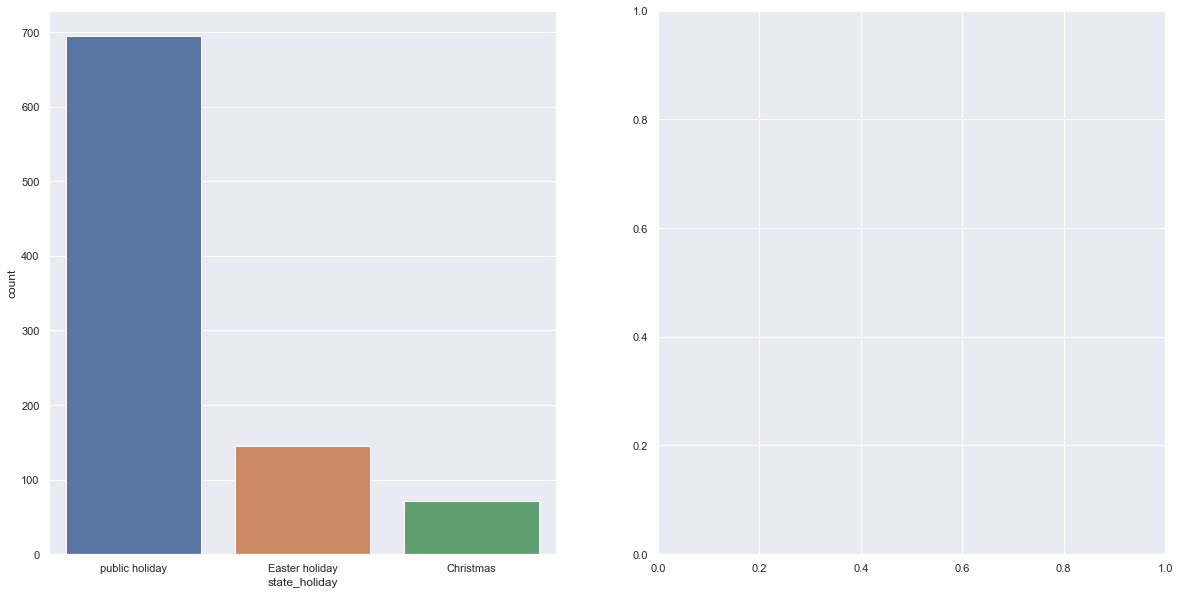

In [38]:
#state_holiday
plt.subplot(1, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(1, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
#store_type
#assortment

## 4.2 Analysis Bivariate

### 4.2.1 - Hipoteses

### H1- Lojas com competidores mais próximos deveriam vender menos.
**False** Lojas com competidores mais próximos vendem MAIS

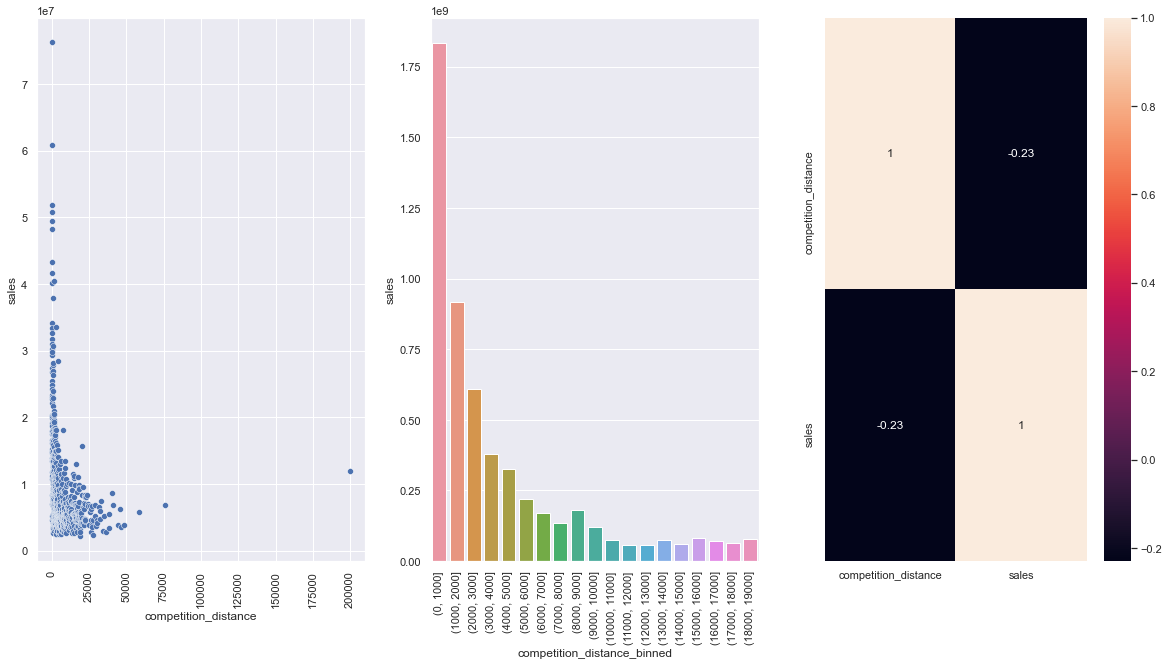

In [39]:
aux01= df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

#Plotagem de gráficos
plt.subplot(1,3,1)# Uma Linha, 3 colunas , Primeira Posição
sns.scatterplot(x='competition_distance', y='sales', data= aux01);
plt.xticks(rotation=90);

bins = list(np.arange(0,20000,1000))
aux01['competition_distance_binned'] = pd.cut(aux01['competition_distance'], bins= bins)
aux02= aux01[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

plt.subplot(1,3,2) # Uma Linha, 3 colunas , Segunda Posição
sns.barplot(x='competition_distance_binned', y='sales', data= aux02);
plt.xticks(rotation=90);

plt.subplot(1,3,3) # Uma Linha, 3 colunas , Terceira Posição

corr = sns.heatmap(aux01.corr(method='pearson'),annot=True)
#bottom, top = corr.get_ylim()
#corr.set_ylim(bottom+0.5, top-0.5)

### H2- Lojas com maior sortimento deveriam vender mais.
**False** Lojas com maior sortimento vendem MENOS

C:\Users\bruna\anaconda3\envs\DataScienceEmProducao\lib\site-packages\pandas\plotting\_matplotlib\core.py:1182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
C:\Users\bruna\anaconda3\envs\DataScienceEmProducao\lib\site-packages\pandas\plotting\_matplotlib\core.py:1182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='year_week'>

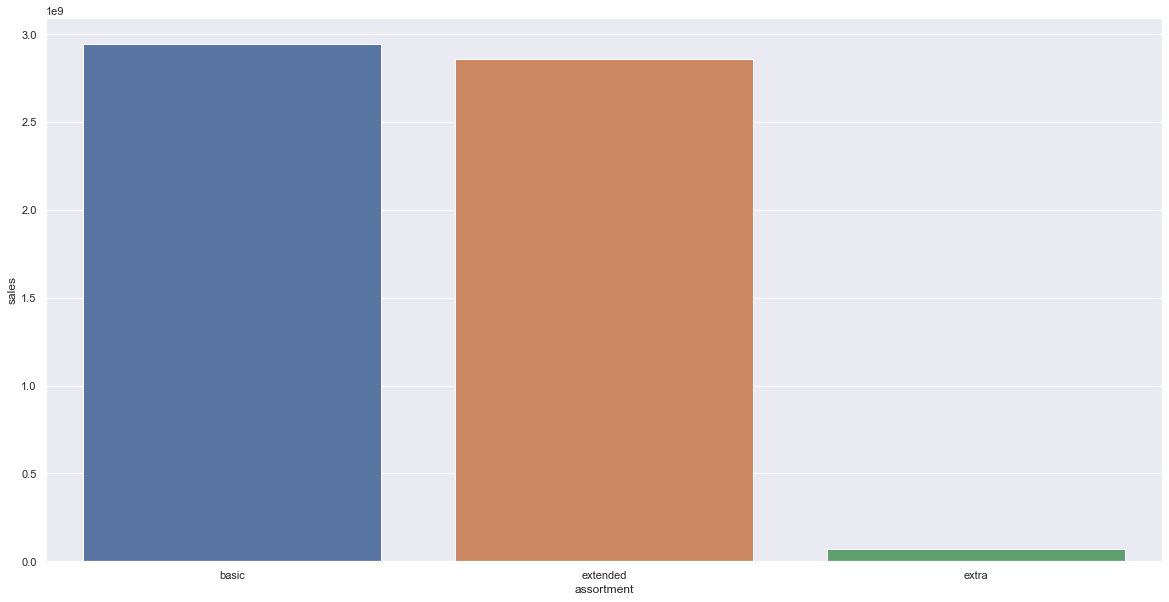

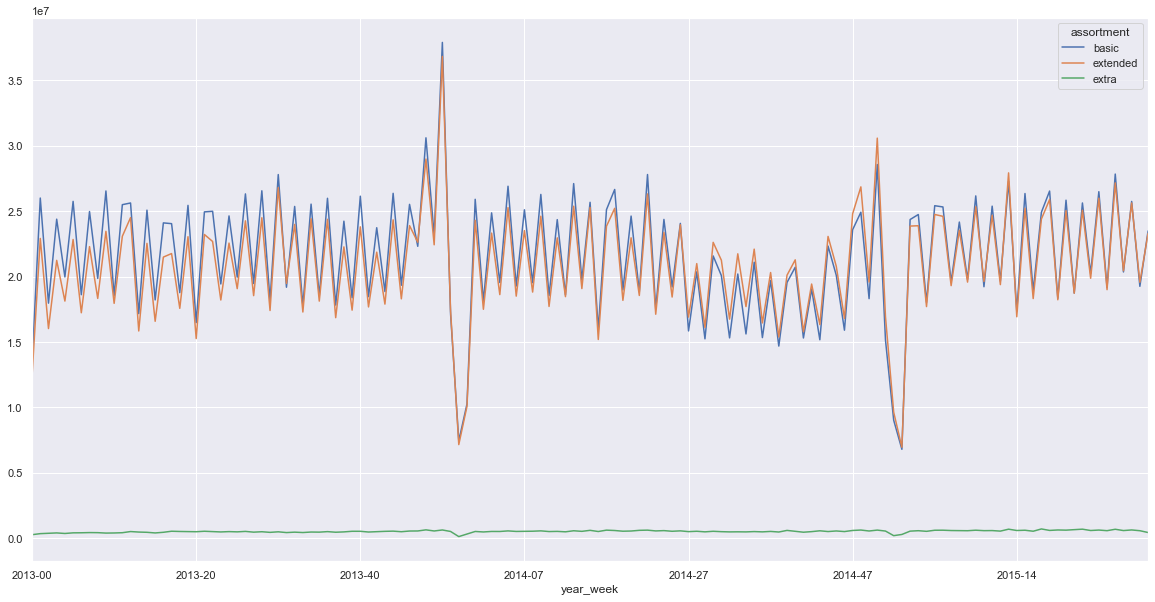

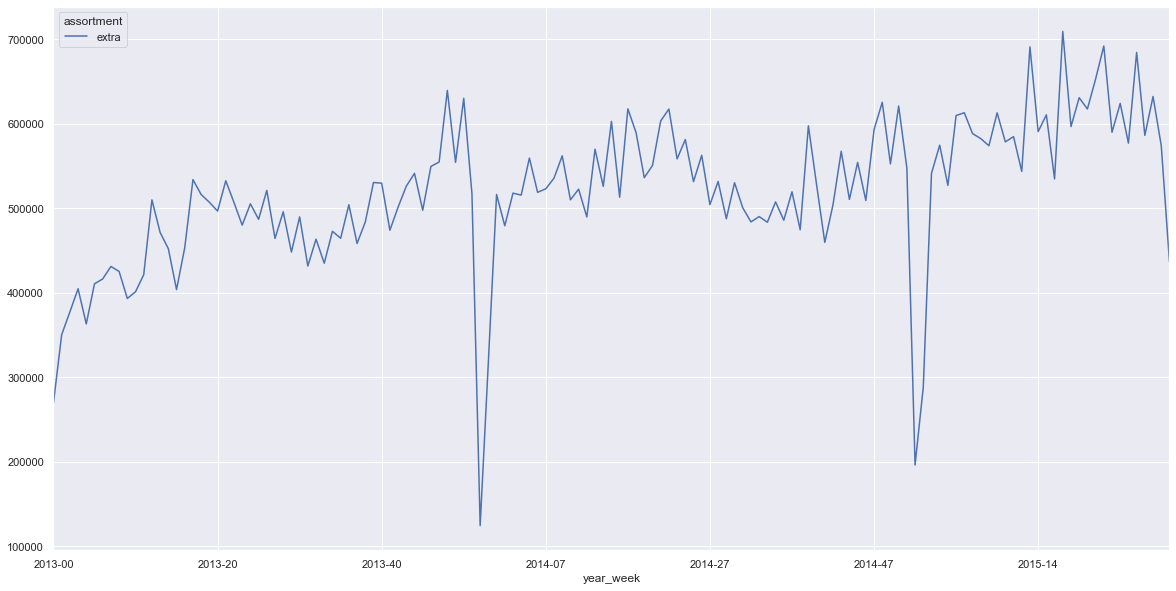

In [40]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()

sns.barplot(x='assortment', y='sales', data= aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()

aux2.pivot(index='year_week', columns='assortment', values='sales').plot()


aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

### H3- Lojas com competidores à mais tempo deveriam vender mais.
**False** Lojas com competidores à mais tempo vendem MENOS

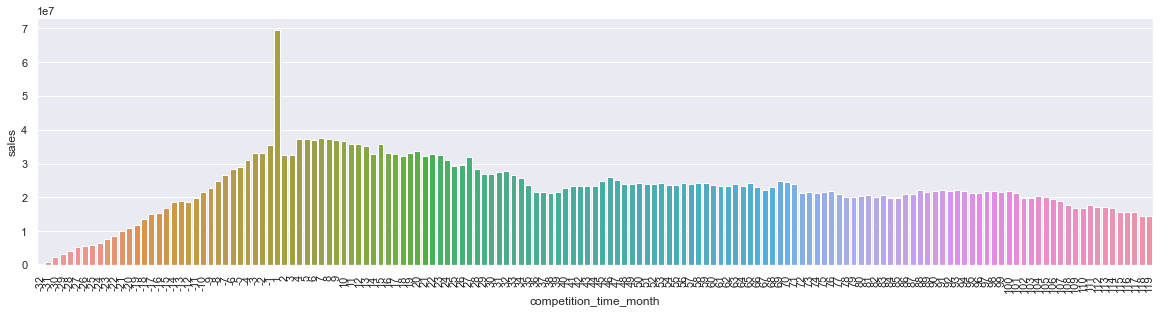

In [41]:
aux01= df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux02 = aux01[(aux01['competition_time_month'] < 120) & (aux01['competition_time_month'] != 0)]


plt.subplot(2,1,1)
sns.barplot(x='competition_time_month', y='sales', data= aux02);
plt.xticks(rotation=90);










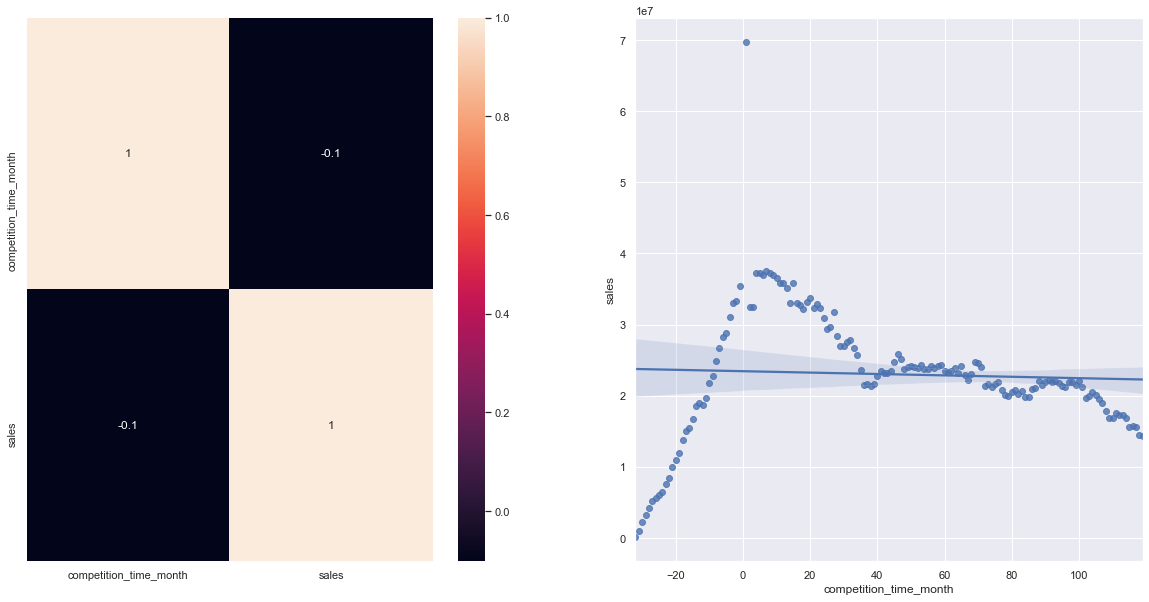

In [42]:
plt.subplot(1,2,1)
corr = sns.heatmap(aux01.corr(method='pearson'),annot=True);

plt.subplot(1,2,2)
sns.regplot(x='competition_time_month', y='sales', data= aux02);

### H4- Lojas com promoções ativas por mais tempo deveriam vender mais.
**False** Lojas com promoções ativas por mais tempo Vendem MENOS

<AxesSubplot:>

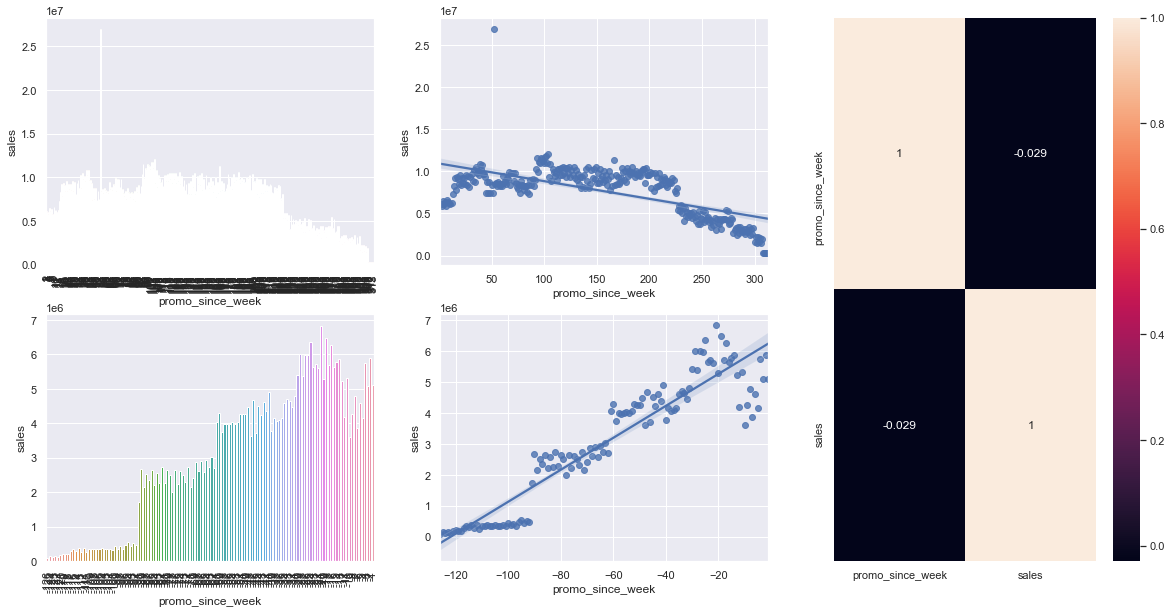

In [43]:
aux1= df4[['promo_since_week', 'sales']].groupby('promo_since_week').sum().reset_index()


grid =GridSpec(2,3)


plt.subplot(grid[ 0, 0])
aux2= aux1[aux1['promo_since_week'] > 0 ] #promo extendido
sns.barplot(x='promo_since_week', y= 'sales', data = aux2);
plt.xticks(rotation=90);

plt.subplot(grid[ 0, 1])
sns.regplot(x='promo_since_week', y= 'sales', data = aux2);


plt.subplot(grid[ 1, 0])
aux3= aux1[aux1['promo_since_week'] < 0 ] # promo regular
sns.barplot(x='promo_since_week', y= 'sales', data = aux3);
plt.xticks(rotation=90);

plt.subplot(grid[ 1, 1])
sns.regplot(x='promo_since_week', y= 'sales', data = aux3);

plt.subplot (grid[ :, 2])
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### <s> H5- Lojas com mais dias de promoção deveriam vender mais. </s>


### H6- Lojas com mais promoções consecutivas deveriam vender mais.
**False** Lojas com mais promoções consecutivas vendem MENOS

In [44]:
df4[['promo', 'promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


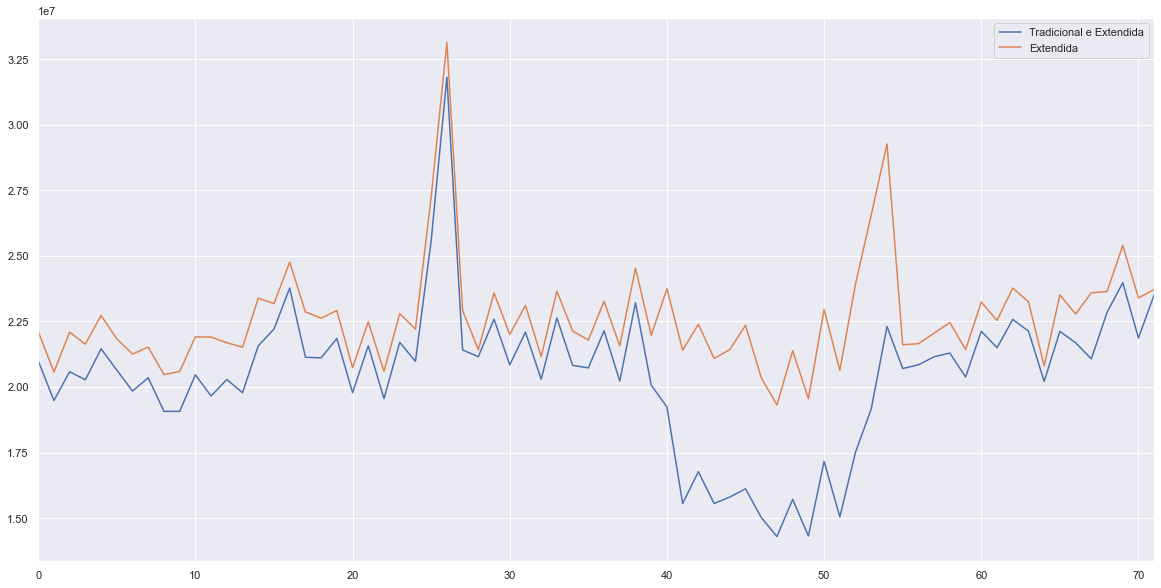

In [45]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional e Extendida','Extendida'])

### H7- Lojas abertas durante o feriado de Natal deveriam vender mais.
**False** Lojas abertas durante o feriado de Natal vendem MENOS

In [46]:
df4.head(3)

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_since_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226


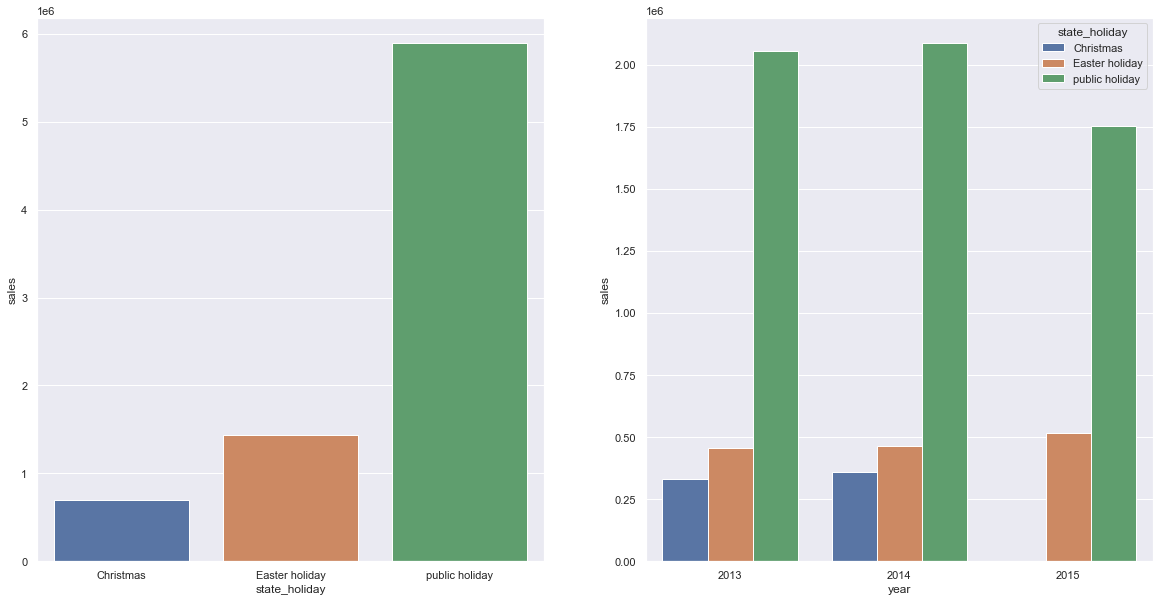

In [47]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1,2,2)
aux2= aux[['year', 'state_holiday', 'sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue= 'state_holiday', data=aux2);

### H8- Lojas deveriam vender mais ao longo dos anos
**False** Lojas vendem MENOS ao longo dos anos

<AxesSubplot:>

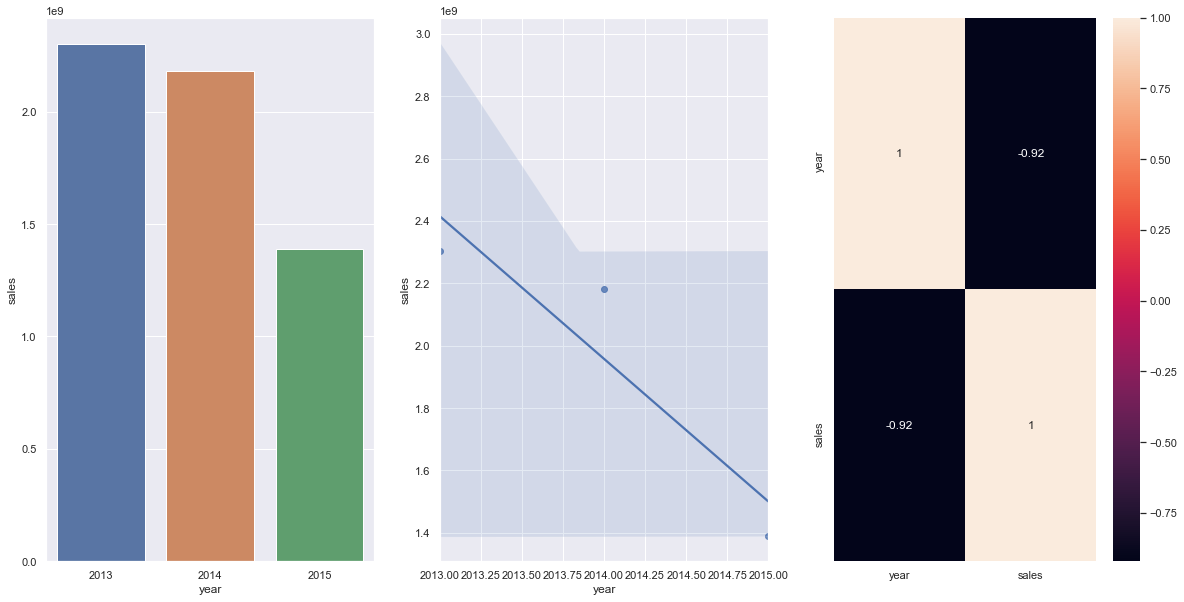

In [48]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data= aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data= aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)



### H9- Lojas deveriam vender mais no segundo semestre do ano.
**False** Lojas vendem MENOS no segundo semestre do ano

<AxesSubplot:>

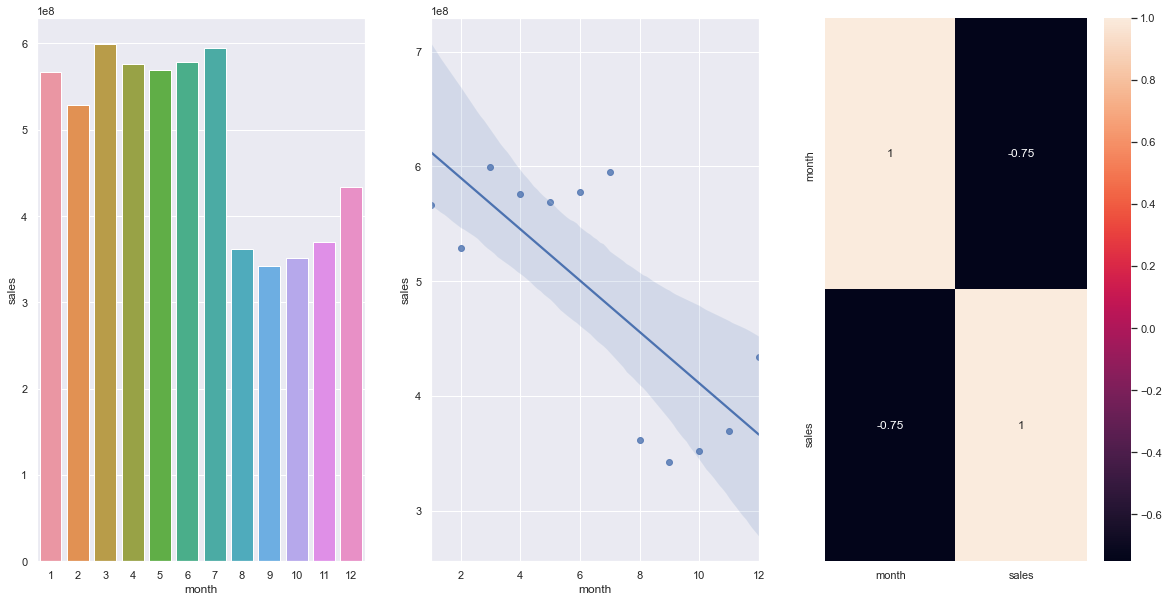

In [49]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data= aux1);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data= aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)

### H10- Lojas deveriam vender mais depois do dia 10 de cada mês.

**True** 

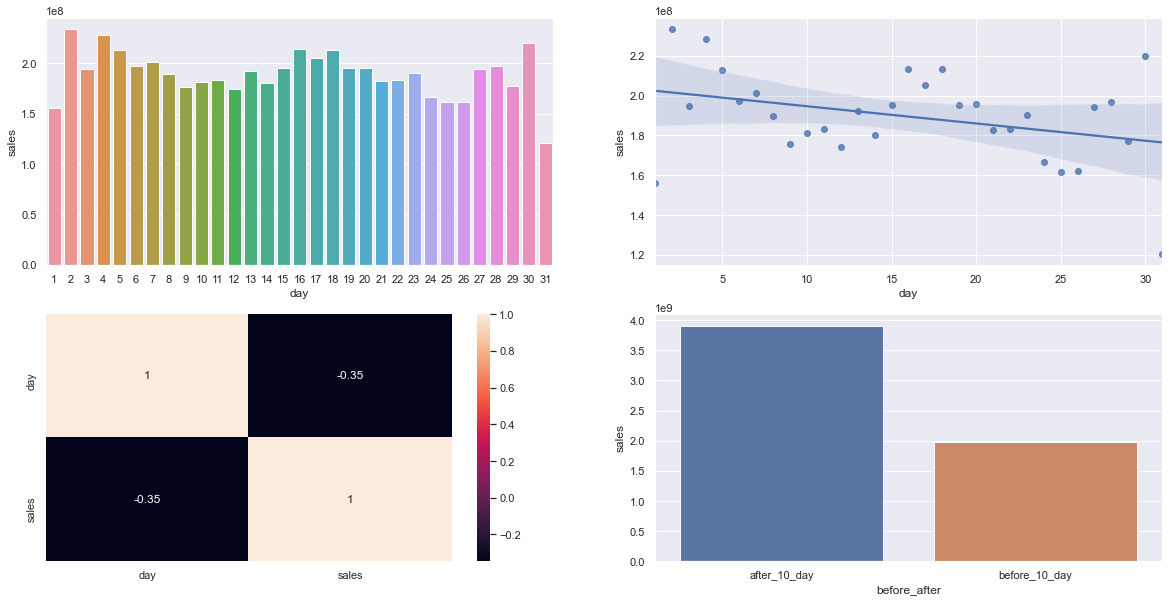

In [50]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data= aux1);

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data= aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_day' if x <= 10 else 'after_10_day')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data= aux2);

### H11- Lojas deveriam vender menos aos finais de semana.
**True** 

<AxesSubplot:>

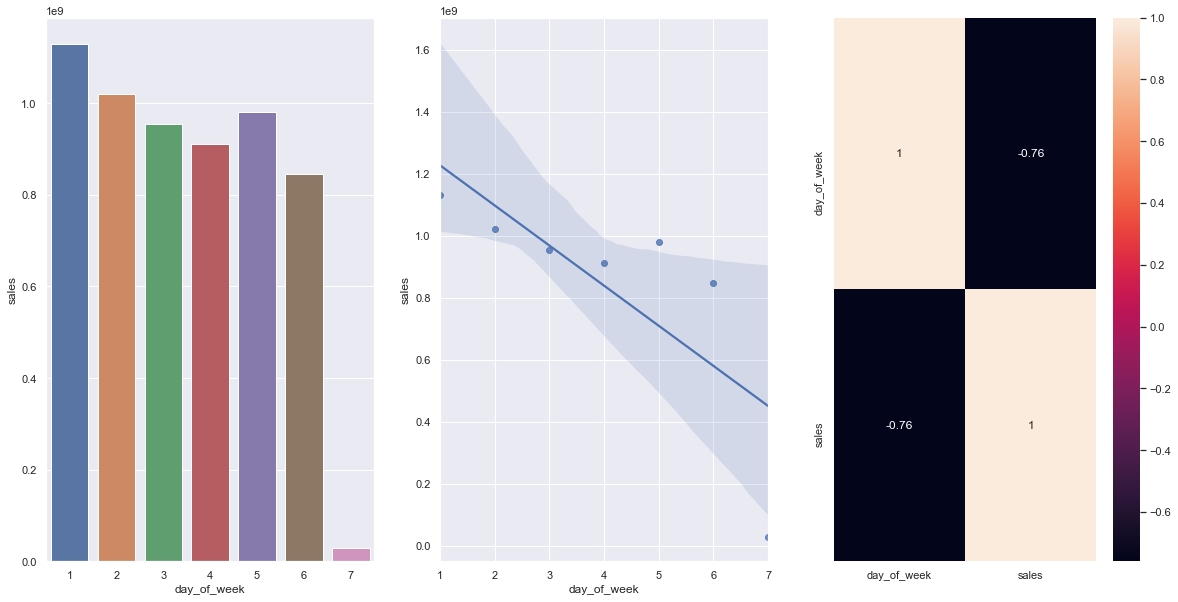

In [51]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data= aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data= aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)

### H12- Lojas deveriam vender menos durante os feriados escolares.
**TRUE** Lojas vendem menos durantes os feriados escolares exceto julho e agosto

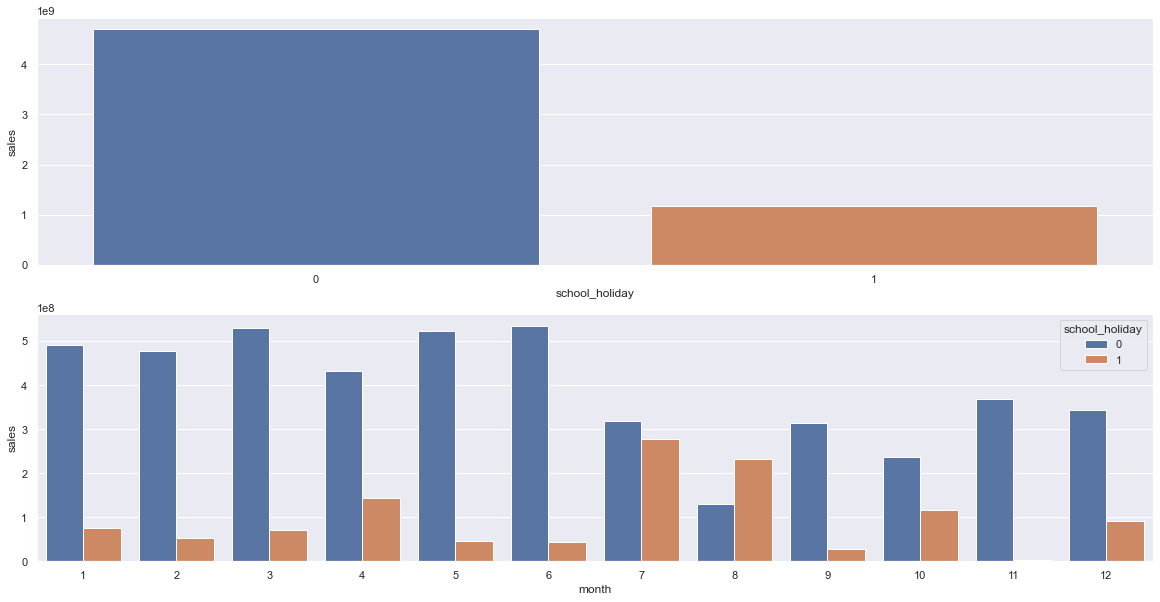

In [52]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data= aux1);

plt.subplot(2,1,2)
aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales',hue='school_holiday', data= aux2);


### 4.2.2 - Resumo das Hipoteses

In [53]:
tab =[['Hipotese', 'Conclusão','Relevância'],
       ['H1','Falsa', 'Baixa'],
       ['H2','Falsa', 'Média'],
       ['H3','Falsa', 'Média'],
       ['H4','Falsa', 'Baixa'],
       ['H5','---', '---'],
       ['H6','Falsa', 'Baixa'],
       ['H7','Falsa', 'Média'],
       ['H8','Falsa', 'Alta'], 
       ['H9','Falsa', 'Alta'], 
       ['H10','Verdadeira', 'Alta'],
       ['H11','Verdadeira', 'Alta'],
       ['H12','Verdadeira', 'Baixa'],
] 

print(tabulate(tab, headers='firstrow'))

Hipotese    Conclusão    Relevância
----------  -----------  ------------
H1          Falsa        Baixa
H2          Falsa        Média
H3          Falsa        Média
H4          Falsa        Baixa
H5          ---          ---
H6          Falsa        Baixa
H7          Falsa        Média
H8          Falsa        Alta
H9          Falsa        Alta
H10         Verdadeira   Alta
H11         Verdadeira   Alta
H12         Verdadeira   Baixa


## 4.3 


### 4.3.1 - Numerical Attributes

<AxesSubplot:>

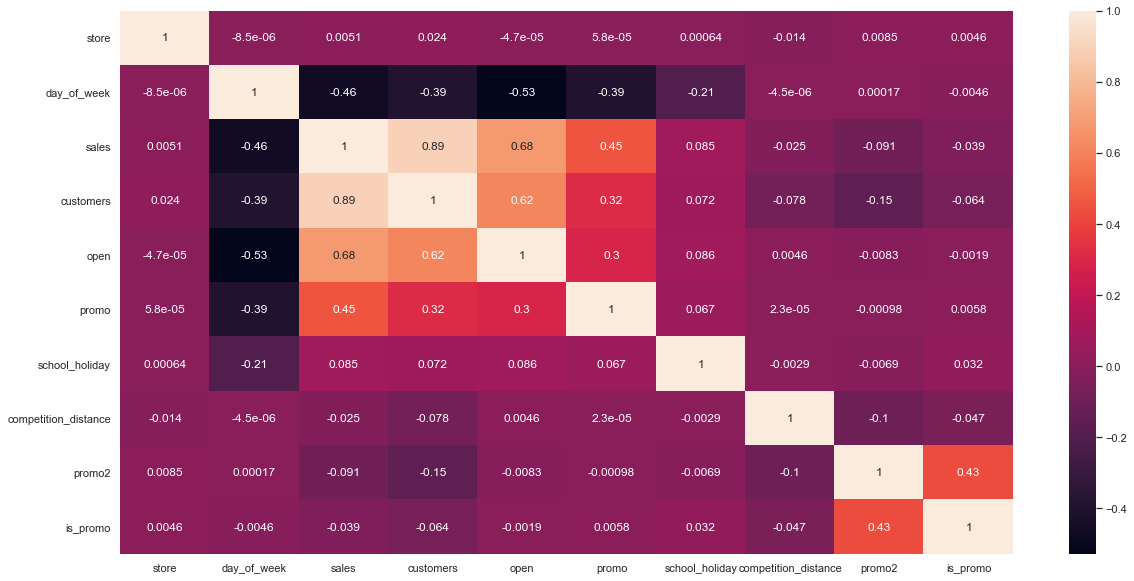

In [54]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)

### 4.3.2 - Categorical Attributes

C:\Users\bruna\anaconda3\envs\DataScienceEmProducao\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


<AxesSubplot:>

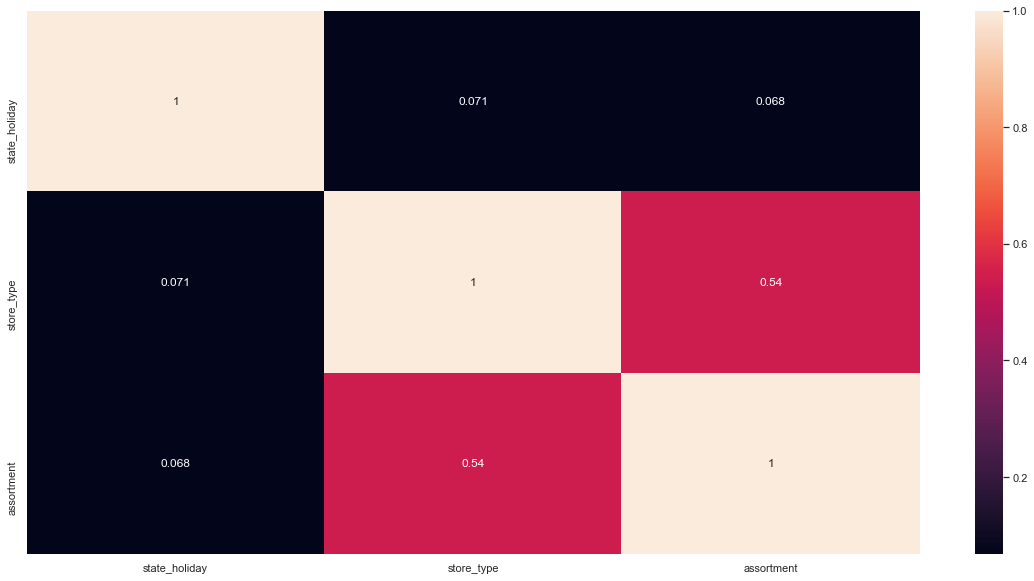

In [55]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]  })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True )